In [3]:
from datetime import datetime
from importlib import reload

import numpy as np

import FewShotCVRP.bo_pure as bo_pure

reload(bo_pure)

sigma = 0.5


def f_true(x: np.ndarray) -> float:
    return np.sin(3 * x[0]) + 0.5 * x[0] ** 2


def f1(x: np.ndarray) -> float:
    return f_true(x) + sigma * np.random.standard_normal()


def f1_batch(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X, dtype=float)
    return np.array([f1(x) for x in X], dtype=float)

bo = bo_pure.BayesianOptimizer(
    f1,
    f_batch=f1_batch,
    bounds=[(-2.0, 2.0)],
    n_init=10,
    n_iter=20,
    sigma=None,
    noise_std_guess=0.5,
    noise_std_bounds=(0.1, 1.0),
    kernel="rbf",
    length_scale_bounds=(0.1, 10.),
    c_factor_bounds=(1/2, 4.),
    suggestions_per_step=3,  # 3 diverse local maxima of EI per iteration
    diversity_frac=0.1,  # 10% of average box size as min separation
    random_state=42,
)
result = bo.run()
gp = bo.get_gp()
print("Best x:", result["x_obs_best"], "Best y:", result["y_obs_best"])
print("Kernel:", gp.kernel_)
print("\nARD report:")
bo.report_ard()
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%Hh%Mm%Ss")
bo.save_snapshot(f"../outputs/bo-experiments-{current_time}", result)


Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 3 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Selected 1 new points
Best x: [-0.39830268] Best y: -2.187648965657965
Kernel: 1.32**2 * RBF(length_scale=0.505) + WhiteKernel(noise_level=0.253)

ARD report:
feature    length_scale        1/length
---------------------------------------
x0             0.505385         1.97869


PosixPath('../outputs/bo-experiments-2025-08-27-14h53m37s')

In [ ]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()


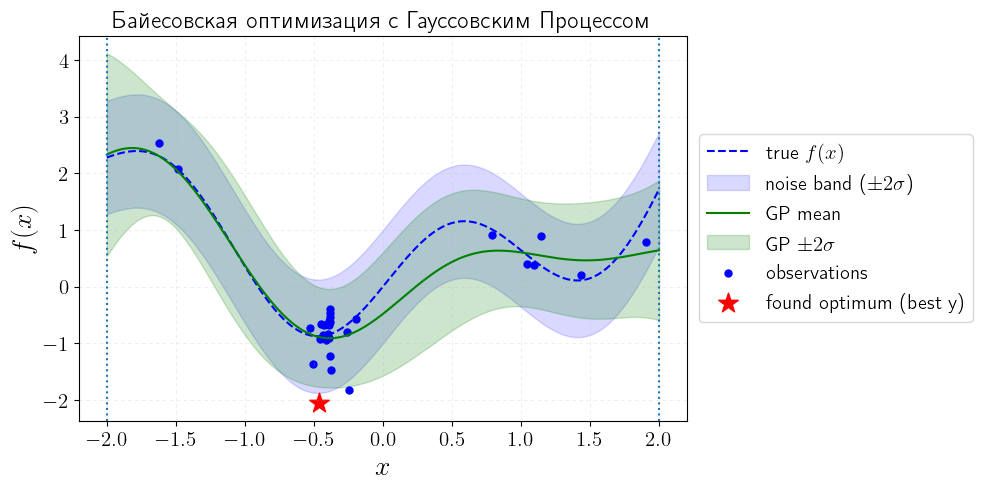

In [ ]:
import matplotlib.pyplot as plt

# Existing from the context
gp = bo.get_gp()
bounds = (-2, 2)
idx = int(np.argmin(bo.y_) if bo.minimize else np.argmax(bo.y_))
res = {
    "x_best": bo.X_[idx].copy(),
    "y_best": float(bo.y_[idx]),
    "X": bo.X_.copy(),
    "y": bo.y_.copy(),
}
x_rec, y_rec = bo.recommend()

# Prepare grid
Xmin, Xmax = bounds
X_plot = np.linspace(Xmin, Xmax, 600).reshape(-1, 1)
y_true = np.array([f_true(x) for x in X_plot])
mu, std = gp.predict(X_plot, return_std=True)

# Noise band around the true function (±sigma)
y_low_noise = y_true - 2 * sigma
y_high_noise = y_true + 2 * sigma

# Extract observations and best point
X_obs = res["X"]
y_obs = res["y"]
# x_best = res["x_best"].reshape(-1)
# y_best = res["y_best"]
x_best = x_rec
y_best = y_rec

# Plot
fig, ax = plt.subplots(figsize=(9, 5))

# True function
ax.plot(X_plot[:, 0], y_true,linestyle="--", label="true $f(x)$", c="blue")

# Noise band around true function
ax.fill_between(
    X_plot[:, 0], y_low_noise, y_high_noise, alpha=0.15, label="noise band ($\pm 2\sigma$)", color="blue"
)

# GP mean and ±2σ
ax.plot(X_plot[:, 0], mu, linestyle="-", label="GP mean", c="green")
ax.fill_between(X_plot[:, 0], mu - 2 * std, mu + 2 * std, alpha=0.2, label="GP $\pm 2\sigma$", color="green")

# Observations
ax.scatter(X_obs[:, 0], y_obs, s=25, label="observations", c="blue")

# Found optimum
ax.scatter([x_best[0]], [y_best], c="red", marker="*", s=220, label="found optimum (best y)")

# Bounds
ax.axvline(Xmin, linestyle=":")
ax.axvline(Xmax, linestyle=":")

ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$f(x)$", fontsize=20)
# ax.set_title("Bayesian Optimization with GP")
ax.set_title("Байесовская оптимизация с Гауссовским Процессом")

# Legend outside (right side)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)

ax.grid(True, alpha=0.3)

# Leave room on the right for the legend
fig.subplots_adjust(right=0.8)

In [4]:
from FewShotCVRP.bo_pure import BayesianOptimizer
snap = BayesianOptimizer.load_snapshot("../outputs/bo-static-2025-08-15-10h54m41s")

gp = snap.gp
X = snap.arrays["X_"]
y = snap.arrays["y_"]
print("Kernel:", gp.kernel_)
print("Best:", snap.result["x_best"], snap.result["y_best"])
mu, std = gp.predict(X[:3], return_std=True)
print("Posterior @ first 3 points:", mu, std)

Kernel: 0.728**2 * RBF(length_scale=[10.6, 1.64e+03])
Best: [83.24088675287318, 20.571508341225588] 46900.0
Posterior @ first 3 points: [49629.1229965  49629.16747136 49629.13502321] [752.28488627 752.28894424 752.28674345]


In [6]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()

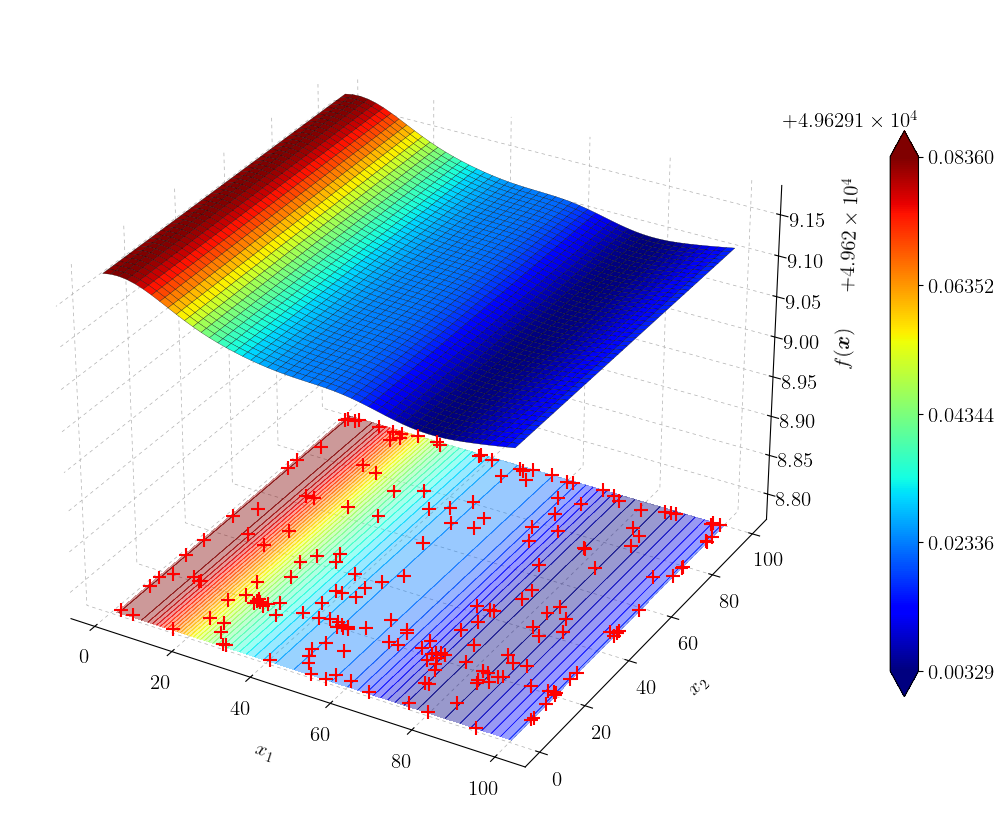

In [11]:
from scipy.interpolate import CloughTocher2DInterpolator
import numpy as np


def compose_points_2D(x, y):
    points = []
    X, Y = np.meshgrid(x, y)
    for i in range(len(X)):
        for j in range(len(X)):
            points.append(np.array([X[i][j], Y[i][j]]))
    return np.array(points)


def filter_X_star(X_star, X_data):
    todel = np.zeros(len(X_star), dtype=bool)
    for p in X_data:
        for i, p_star in enumerate(X_star):
            if np.linalg.norm(p - p_star) < 1e-6:
                todel[i] = True
    X_star_1 = []
    for i, p_star in enumerate(X_star):
        if not todel[i]:
            X_star_1.append(p_star.copy())
    return np.array(X_star_1)


def plot_posterior_gp_samples(X_data, y_data, gp):
    # covar_func = lambda x1, x2: mygp.SE_covariance_function(x1, x2, 1.0)
    x1_lims = (1.0, 100.0)
    x2_lims = (1.0, 100.0)
    f = myplots.rastrigin
    # X_data = np.array([[-2, 2], [2, 2], [0, 0], [2, -2], [-2, -2]])
    # y_data = np.array([f(x) for x in X_data])
    N = 20
    x1 = np.linspace(*x1_lims, N)
    x2 = np.linspace(*x2_lims, N)
    X_star = compose_points_2D(x1, x2)
    X_star = filter_X_star(X_star, X_data)
    # values = gp_output_scaling(X_data, y_data, X_star, covar_func, is_sample=False)
    values = gp.predict(X_star)
    points = np.array(X_data.tolist() + X_star.tolist())
    values = np.array(y_data.tolist() + values.tolist())
    # sampled_func = CloughTocher2DInterpolator(points, values)
    sampled_func = lambda p: gp.predict(np.array([p]))
    myplots.plot_3D_surface(
        x1_lims,
        x2_lims,
        sampled_func,
        X_data,
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=50,
        zfactor=2.0,
    )

plot_posterior_gp_samples(X, y, gp)

In [23]:
from scipy.optimize import minimize

bounds = np.array(snap.arrays["bounds"])

def uniform_in_bounds(bounds, n: int, dim=2) -> np.ndarray:
    low, high = bounds[:, 0], bounds[:, 1]
    return np.random.random((n, dim)) * (high - low) + low

n_starts = 25
def fun(x):
    m, _ = gp.predict(np.asarray(x).reshape(1, -1), return_std=True)
    return float(m[0])
starts = uniform_in_bounds(bounds, n_starts, 2)
best_x, best_v = None, np.inf
for x0 in starts:
    res = minimize(fun, x0=x0, method="L-BFGS-B", bounds=bounds.tolist())
    if res.success and res.fun < best_v:
        best_x, best_v = res.x, res.fun

In [26]:
best_x, best_v

(array([80.91820057, 94.50485408]), 49629.10333925977)

In [18]:
[print(x_,y_) for x_,y_ in zip(X, y)]

[51.67034085 95.09590594] 50851.0
[15.27180166 94.91629527] 50205.0
[31.87131375 42.90931845] 50035.0
[82.94255679 41.5107145 ] 49071.0
[55.40977508  3.72835221] 49725.0
[75.59779776 54.27618801] 49507.0
[33.64343993 79.05444164] 49332.0
[31.0162881  45.89629106] 49581.0
[14.27012803 40.90818566] 50710.0
[21.14206883 26.9690207 ] 49693.0
[75.28610259 28.76046704] 48743.0
[49.03390647 98.09298278] 50009.0
[96.20406217 72.75420414] 50269.0
[54.5814587 28.4122292] 49924.0
[16.90454887 97.02261591] 50815.0
[52.09078997 12.47069563] 49445.0
[62.7254858  77.89162832] 50829.0
[61.6873268  91.81247277] 49792.0
[ 4.91969479 53.33033706] 51555.0
[46.47425241  7.17260834] 49938.0
[64.49148874 85.41065101] 50312.0
[59.70116079 26.74964733] 48210.0
[84.14827058 51.44009227] 49674.0
[51.57799956 75.54999056] 48463.0
[15.64428154 82.14304519] 50768.0
[68.64540369 78.92259721] 50281.0
[19.97000964 80.43405195] 49989.0
[19.94106868  9.07370912] 49275.0
[85.66747045 86.26706612] 50600.0
[87.77717255 47.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [1]:
from FewShotCVRP.bo_pure import BayesianOptimizer
snap = BayesianOptimizer.load_snapshot("../outputs/bo-control-2025-08-23-11h35m26s")

gp = snap.gp
X = snap.arrays["X_"]
y = snap.arrays["y_"]
print("Kernel:", gp.kernel_)
print("Best:", snap.result["x_best"], snap.result["y_best"])
mu, std = gp.predict(X[:3], return_std=True)
print("Posterior @ first 3 points:", mu, std)

Kernel: 0.714**2 * RBF(length_scale=[2.27e+04, 37.2, 8.99e+03, 236, 7.75e+05, 0.765, 7.73, 2.31, 8.41, 0.0136, 0.286, 1.24e+05, 1.75e+04, 0.014, 0.0757, 9.3, 0.0509, 2.03, 0.058, 0.0404, 1.09e+06, 1.43e+05, 0.308, 8.43e+03, 9.51, 22.4, 61, 0.43, 0.0437, 6.35, 916, 6.29e+03, 4.5e+03, 5.15, 0.448, 579, 1.19, 0.163, 38.5, 6.82e+03, 2.35e+03, 120, 191, 3.17e+05, 0.0603, 2.01e+05, 3.27e+04, 8.23e+06, 16.1, 2.84e+05, 1.33, 0.153, 1.33e+04, 0.454, 499, 0.0272, 517, 1.66e+05, 0.0224, 7.79e+04, 0.439, 1.45e+03, 1.03e+05, 1.29e+04, 0.157, 0.0103, 3.62e+04, 274, 0.0111, 9.18e+05, 1.66, 1.77e+06, 324, 1.18e+03, 995, 1.67e+06, 917, 9.23, 3.5, 0.259, 1.38e+04, 0.705, 1.92e+03, 8.4, 9.38e+03, 97.7, 109, 3.03, 1.62e+03, 6.04e+03, 0.0431, 1.06e+03, 4.42, 0.0382, 1.07, 148, 9.34e+06, 0.0361, 1.27e+03, 4.22e+03, 2.88e+06, 2.93e+05, 2.16e+05, 1.07e+05, 3.38e+06, 5.2e+03, 6.04, 2.91e+04, 9.32e+03, 4.1e+03, 199, 1.37e+05, 3.23e+06, 96.3, 9.32e+06, 1.1e+06, 2.77, 1.96e+03, 1.55e+04, 2.78e+03, 0.229, 4.86e+06

In [22]:
from importlib import reload

import numpy as np

import FewShotCVRP.ea as ea
import FewShotCVRP.examples.params_search.nn as mynn

reload(mynn)
reload(ea)


random_seed = 3
constants = mynn.SimulationConstants(
    cvrp_instance_str="X-n101-k25.xml",
    random_seed=random_seed,
    ea_window_size=5,
    ea_generations_number=50,
    ea_lambda_=2 * 10**4,
    ea_mutation_operator=ea.mutate_shift_2opt_fast_fast,
    in_dim=10,
    hidden_dims=[15],
    theta_min=1.0,
    theta_max=100.0,
    activation=mynn.nn.SiLU,
)

objective = mynn.NNObjective(
    theta_min=constants.theta_min,
    theta_max=constants.theta_max,
    in_dim=constants.in_dim,
    hidden_dims=constants.hidden_dims,
)
nn_weights = np.array(snap.result["x_best"])
cvrp = mynn.get_cvrp_instance(constants.cvrp_instance_str)


def param_control_wrapper(args, f):
    assert len(args) == 2 * constants.ea_window_size
    recommended_theta = f(args)
    print("Param control arguments:", args)
    print("Recommended theta", recommended_theta)
    return recommended_theta


simulation = lambda predict_theta: ea.one_plus_lambda_ea_with_theta_control(
    cvrp,
    theta_schedule_window=[100.0, 100.0, 50.0, 20.0, 10.0],
    window=constants.ea_window_size,
    theta_control_fun=predict_theta,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)["best_fitness"]


In [23]:
objective(nn_weights, simulation)

[init] fitness=60061.000000
[gen 1] theta=100 fitness=51754.000000 ↑ evals=20001/1000001
[gen 2] theta=100 fitness=50820.000000 ↑ evals=40001/1000001
[gen 3] theta=50 fitness=48268.000000 ↑ evals=60001/1000001
[gen 4] theta=20 fitness=46664.000000 ↑ evals=80001/1000001
[gen 5] theta=10 fitness=45115.000000 ↑ evals=100001/1000001
[gen 6] theta=1 fitness=43825.000000 ↑ evals=120001/1000001
[gen 7] theta=1 fitness=42705.000000 ↑ evals=140001/1000001
[gen 8] theta=1 fitness=41448.000000 ↑ evals=160001/1000001
[gen 9] theta=1 fitness=40421.000000 ↑ evals=180001/1000001
[gen 10] theta=1 fitness=39509.000000 ↑ evals=200001/1000001
[gen 11] theta=1.71 fitness=38836.000000 ↑ evals=220001/1000001
[gen 12] theta=1.85 fitness=38058.000000 ↑ evals=240001/1000001
[gen 13] theta=1.38 fitness=37437.000000 ↑ evals=260001/1000001
[gen 14] theta=1.42 fitness=36526.000000 ↑ evals=280001/1000001
[gen 15] theta=1.15 fitness=36147.000000 ↑ evals=300001/1000001
[gen 16] theta=1.12 fitness=35859.000000 ↑ evals

29624.0

In [12]:
ea.one_plus_lambda_ea_with_theta_schedule(
    cvrp,
    theta_schedule=[1.0] * constants.ea_generations_number,
    seed=constants.random_seed,
    lambda_=constants.ea_lambda_,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    generations_number=constants.ea_generations_number,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=True,
)

[init] fitness=60061.000000
[gen 1] theta=1 fitness=57453.000000 ↑ evals=20001/1000001
[gen 2] theta=1 fitness=54972.000000 ↑ evals=40001/1000001
[gen 3] theta=1 fitness=52623.000000 ↑ evals=60001/1000001
[gen 4] theta=1 fitness=50729.000000 ↑ evals=80001/1000001
[gen 5] theta=1 fitness=49127.000000 ↑ evals=100001/1000001
[gen 6] theta=1 fitness=47807.000000 ↑ evals=120001/1000001
[gen 7] theta=1 fitness=46465.000000 ↑ evals=140001/1000001
[gen 8] theta=1 fitness=44968.000000 ↑ evals=160001/1000001
[gen 9] theta=1 fitness=43480.000000 ↑ evals=180001/1000001
[gen 10] theta=1 fitness=42587.000000 ↑ evals=200001/1000001
[gen 11] theta=1 fitness=41724.000000 ↑ evals=220001/1000001
[gen 12] theta=1 fitness=40851.000000 ↑ evals=240001/1000001
[gen 13] theta=1 fitness=40058.000000 ↑ evals=260001/1000001
[gen 14] theta=1 fitness=39378.000000 ↑ evals=280001/1000001
[gen 15] theta=1 fitness=38695.000000 ↑ evals=300001/1000001
[gen 16] theta=1 fitness=38183.000000 ↑ evals=320001/1000001
[gen 17] 

{'best_perm': array([65, 75,  8, 85, 24,  3, 17,  9, 27,  2, 78, 51, 61, 90, 86, 35, 28,
        47, 74, 29, 84, 10, 95, 58, 81, 71, 56,  4, 73, 68, 12, 40, 19, 45,
        23, 15, 54, 72, 52, 92, 93, 55, 18, 20,  6,  1, 44, 48, 41, 33, 26,
        97, 88, 37, 49, 96, 80, 82, 21, 69, 87, 42, 36,  5, 77, 64, 43, 76,
        66, 16,  7, 59, 13, 62, 38, 11, 34, 22, 99, 60, 79, 63, 39, 57, 14,
         0, 53, 91, 50, 70, 98, 46, 25, 30, 94, 32, 31, 89, 83, 67]),
 'best_fitness': 31131.0,
 'evals': 1000001,
 'gens': 50,
 'history': [(1, 60061.0),
  (20001, 57453.0),
  (40001, 54972.0),
  (60001, 52623.0),
  (80001, 50729.0),
  (100001, 49127.0),
  (120001, 47807.0),
  (140001, 46465.0),
  (160001, 44968.0),
  (180001, 43480.0),
  (200001, 42587.0),
  (220001, 41724.0),
  (240001, 40851.0),
  (260001, 40058.0),
  (280001, 39378.0),
  (300001, 38695.0),
  (320001, 38183.0),
  (340001, 37623.0),
  (360001, 37171.0),
  (380001, 36751.0),
  (400001, 36310.0),
  (420001, 35971.0),
  (440001, 3545

In [14]:
ea.descent(
    cvrp,
    seed=constants.random_seed,
    max_evals=constants.ea_generations_number * constants.ea_lambda_,
    mutation=ea.mutate_shift_2opt_fast_fast,
    verbose=False,
)

{'best_perm': array([59, 58,  2, 63, 33, 90, 26, 99,  7, 20, 22, 16, 79, 50, 61, 51, 73,
        12,  3, 64, 77,  5, 41, 13, 10, 84, 29, 92, 28, 35, 36, 27, 85,  8,
        91, 55, 25, 86, 42, 44,  1, 48,  6, 82, 98, 70, 80, 83, 89, 69, 78,
        49, 34, 19, 45, 57, 76, 87, 39, 24, 81, 71, 56, 43, 23, 30, 94, 31,
        93, 95, 66, 74, 32, 52, 72,  4, 14, 21, 40, 75, 54, 15, 68, 47, 46,
        88, 97, 37, 18, 96, 60, 38,  9, 62, 17, 11,  0, 67, 53, 65]),
 'best_fitness': 28899.0,
 'evals': 1000000,
 'gens': 999999,
 'history': [(1, 60061.0),
  (2, 59686.0),
  (3, 59026.0),
  (4, 58085.0),
  (5, 58085.0),
  (6, 58085.0),
  (7, 58085.0),
  (8, 58085.0),
  (9, 57007.0),
  (10, 57007.0),
  (11, 57007.0),
  (12, 57007.0),
  (13, 56673.0),
  (14, 56673.0),
  (15, 56574.0),
  (16, 56483.0),
  (17, 56483.0),
  (18, 56483.0),
  (19, 56440.0),
  (20, 56440.0),
  (21, 56061.0),
  (22, 55899.0),
  (23, 55899.0),
  (24, 55899.0),
  (25, 55899.0),
  (26, 55899.0),
  (27, 55890.0),
  (28, 55604.0

In [16]:
a=np.arange(1,101)
type(a)

numpy.ndarray

In [ ]:
import torch

print(torch.__version__)

2.8.0+cu128
